In [8]:
import cv2
import json
from matplotlib import pyplot as plt
import numpy as np
import os
import random
import keras.models

# import a lot of things from keras:
# sequential model
from keras.models import Sequential

# layers
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, RandomFlip, RandomRotation, RandomContrast, RandomBrightness

# loss function
from keras.metrics import categorical_crossentropy

# callback functions
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# convert data to categorial vector representation
from keras.utils import to_categorical

# nice progress bar for loading data
from tqdm.notebook import tqdm

# helper function for train/test split
from sklearn.model_selection import train_test_split

# import confusion matrix helper function
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# import pre-trained model
from keras.applications.vgg16 import VGG16

# include only those gestures
CONDITIONS = ['like', 'dislike', 'stop', 'rock', 'peace']
label_names = CONDITIONS.copy()

# image size
IMG_SIZE = 64
SIZE = (IMG_SIZE, IMG_SIZE)

# number of color channels we want to use
# set to 1 to convert to grayscale
# set to 3 to use color images
COLOR_CHANNELS = 3

PATH = '../gesture_dataset_sample'

## helper function to load and parse annotations

In [4]:
annotations = dict()

for condition in CONDITIONS:
    with open(f'{PATH}/_annotations/{condition}.json') as f:
        annotations[condition] = json.load(f)

In [5]:
# pretty-print first element
#000484ab-5fd0-49b8-9253-23a22b71d7b1
print(json.dumps(annotations['like']['0014182f-d756-42b3-896c-c52de76926bb'], indent=2))

{
  "bboxes": [
    [
      0.38056273,
      0.35650891,
      0.17322347,
      0.10461114
    ]
  ],
  "labels": [
    "like"
  ],
  "landmarks": [
    [
      [
        0.5497169170918876,
        0.4276043615779976
      ],
      [
        0.5218336293004483,
        0.40536586667786917
      ],
      [
        0.48288133220125257,
        0.3930262243722419
      ],
      [
        0.4501841862302019,
        0.37981099195030416
      ],
      [
        0.44251365410099686,
        0.36620499322043343
      ],
      [
        0.43138297470865106,
        0.406093902776592
      ],
      [
        0.4072660997339628,
        0.4073950234480344
      ],
      [
        0.42588200316326846,
        0.40612291879594015
      ],
      [
        0.4441470003072778,
        0.4049221293588555
      ],
      [
        0.4314493576491367,
        0.4212979654419442
      ],
      [
        0.42096276272263283,
        0.4180224457320293
      ],
      [
        0.43966095717106257,
      

## helper function to pre-process images (color channel conversion and resizing)

In [6]:
def preprocess_image(img):
    if COLOR_CHANNELS == 1:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_resized = cv2.resize(img, SIZE)
    return img_resized

## load images and annotations

In [7]:
images = [] # stores actual image data
labels = [] # stores labels (as integer - because this is what our network needs)
#label_names = [] # maps label ints to their actual categories so we can understand predictions later

# loop over all conditions
# loop over all files in the condition's directory
# read the image and corresponding annotation
# crop image to the region of interest
# preprocess image
# store preprocessed image and label in corresponding lists
for condition in CONDITIONS:
    for filename in tqdm(os.listdir(f'{PATH}/{condition}')):
        # extract unique ID from file name
        UID = filename.split('.')[0]
        img = cv2.imread(f'{PATH}/{condition}/{filename}')
        
        # get annotation from the dict we loaded earlier
        try:
            annotation = annotations[condition][UID]
        except Exception as e:
            print(e)
            continue
        
        # iterate over all hands annotated in the image
        for i, bbox in enumerate(annotation['bboxes']):
            # annotated bounding boxes are in the range from 0 to 1
            # therefore we have to scale them to the image size
            x1 = int(bbox[0] * img.shape[1])
            y1 = int(bbox[1] * img.shape[0])
            w = int(bbox[2] * img.shape[1])
            h = int(bbox[3] * img.shape[0])
            x2 = x1 + w
            y2 = y1 + h
            
            # crop image to the bounding box and apply pre-processing
            crop = img[y1:y2, x1:x2]
            preprocessed = preprocess_image(crop)
            
            # get the annotated hand's label
            # if we have not seen this label yet, add it to the list of labels
            label = annotation['labels'][i]

            # Nur erlaubte Labels übernehmen
            if label not in CONDITIONS:
                print(f"⚠️ Unbekanntes Label übersprungen: {label}")
                continue  # springe zum nächsten Datensatz

            # label_names gar nicht mehr dynamisch erzeugen
            label_index = CONDITIONS.index(label)

            images.append(preprocessed)
            labels.append(label_index)

  0%|          | 0/250 [00:00<?, ?it/s]

⚠️ Unbekanntes Label übersprungen: no_gesture
⚠️ Unbekanntes Label übersprungen: no_gesture
⚠️ Unbekanntes Label übersprungen: no_gesture
⚠️ Unbekanntes Label übersprungen: no_gesture
⚠️ Unbekanntes Label übersprungen: no_gesture
⚠️ Unbekanntes Label übersprungen: no_gesture
⚠️ Unbekanntes Label übersprungen: no_gesture
⚠️ Unbekanntes Label übersprungen: no_gesture
⚠️ Unbekanntes Label übersprungen: no_gesture
⚠️ Unbekanntes Label übersprungen: no_gesture
⚠️ Unbekanntes Label übersprungen: no_gesture
⚠️ Unbekanntes Label übersprungen: no_gesture
⚠️ Unbekanntes Label übersprungen: no_gesture
⚠️ Unbekanntes Label übersprungen: no_gesture
⚠️ Unbekanntes Label übersprungen: no_gesture
⚠️ Unbekanntes Label übersprungen: no_gesture
⚠️ Unbekanntes Label übersprungen: no_gesture
⚠️ Unbekanntes Label übersprungen: no_gesture
⚠️ Unbekanntes Label übersprungen: no_gesture
⚠️ Unbekanntes Label übersprungen: no_gesture
⚠️ Unbekanntes Label übersprungen: no_gesture
⚠️ Unbekanntes Label übersprungen:

  0%|          | 0/250 [00:00<?, ?it/s]

⚠️ Unbekanntes Label übersprungen: no_gesture
⚠️ Unbekanntes Label übersprungen: no_gesture
⚠️ Unbekanntes Label übersprungen: no_gesture
⚠️ Unbekanntes Label übersprungen: no_gesture
⚠️ Unbekanntes Label übersprungen: no_gesture
⚠️ Unbekanntes Label übersprungen: no_gesture
⚠️ Unbekanntes Label übersprungen: no_gesture
⚠️ Unbekanntes Label übersprungen: no_gesture
⚠️ Unbekanntes Label übersprungen: no_gesture
⚠️ Unbekanntes Label übersprungen: no_gesture
⚠️ Unbekanntes Label übersprungen: no_gesture
⚠️ Unbekanntes Label übersprungen: no_gesture
⚠️ Unbekanntes Label übersprungen: no_gesture
⚠️ Unbekanntes Label übersprungen: no_gesture
⚠️ Unbekanntes Label übersprungen: no_gesture
⚠️ Unbekanntes Label übersprungen: no_gesture
⚠️ Unbekanntes Label übersprungen: no_gesture
⚠️ Unbekanntes Label übersprungen: no_gesture
⚠️ Unbekanntes Label übersprungen: no_gesture
⚠️ Unbekanntes Label übersprungen: no_gesture
⚠️ Unbekanntes Label übersprungen: no_gesture
⚠️ Unbekanntes Label übersprungen:

  0%|          | 0/250 [00:00<?, ?it/s]

⚠️ Unbekanntes Label übersprungen: no_gesture
⚠️ Unbekanntes Label übersprungen: no_gesture
⚠️ Unbekanntes Label übersprungen: no_gesture
⚠️ Unbekanntes Label übersprungen: no_gesture
⚠️ Unbekanntes Label übersprungen: no_gesture
⚠️ Unbekanntes Label übersprungen: no_gesture
⚠️ Unbekanntes Label übersprungen: no_gesture
⚠️ Unbekanntes Label übersprungen: no_gesture
⚠️ Unbekanntes Label übersprungen: no_gesture
⚠️ Unbekanntes Label übersprungen: no_gesture
⚠️ Unbekanntes Label übersprungen: no_gesture
⚠️ Unbekanntes Label übersprungen: no_gesture
⚠️ Unbekanntes Label übersprungen: no_gesture
⚠️ Unbekanntes Label übersprungen: no_gesture
⚠️ Unbekanntes Label übersprungen: no_gesture
⚠️ Unbekanntes Label übersprungen: no_gesture
⚠️ Unbekanntes Label übersprungen: no_gesture
⚠️ Unbekanntes Label übersprungen: no_gesture
⚠️ Unbekanntes Label übersprungen: no_gesture
⚠️ Unbekanntes Label übersprungen: no_gesture
⚠️ Unbekanntes Label übersprungen: no_gesture
⚠️ Unbekanntes Label übersprungen:

KeyboardInterrupt: 

## let's have a look at one of the images

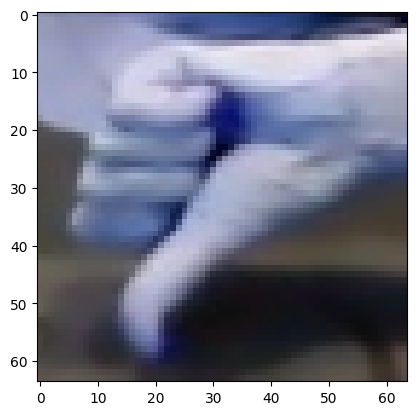

In [14]:
plt.imshow(random.sample(images, 1)[0])

## split data set into train and test

x is for the actual data, y is for the label (this is convention)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

1301
326
1301
326


## transform data sets into a format compatible with our neural network

image data has to be a numpy array with following dimensions: [image_id, y_axis, x_axis, color_channels]

furthermore, scale all values to a range of 0 to 1

training data has to be converted to a categorial vector ("one hot"):

[3] --> [0, 0, 0, 1, 0, ..., 0]

In [16]:
X_train = np.array(X_train).astype('float32')
X_train = X_train / 255.

X_test = np.array(X_test).astype('float32')
X_test = X_test / 255.

y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

train_label = y_train_one_hot
test_label = y_test_one_hot

X_train = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, COLOR_CHANNELS)
X_test = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, COLOR_CHANNELS)

print(X_train.shape, X_test.shape, train_label.shape, test_label.shape)

(1301, 64, 64, 3) (326, 64, 64, 3) (1301, 6) (326, 6)


In [17]:
# variables for hyperparameters
batch_size = 8
epochs = 50
num_classes = len(label_names)
activation = 'leaky_relu'
activation_conv = 'leaky_relu'  # LeakyReLU
layer_count = 2
num_neurons = 64

# define model structure
# with keras, we can use a model's add() function to add layers to the network one by one
model = Sequential()

# data augmentation (this can also be done beforehand - but don't augment the test dataset!)
model.add(RandomFlip('horizontal'))
model.add(RandomContrast(0.1))
#model.add(RandomBrightness(0.1))
#model.add(RandomRotation(0.2))

# first, we add some convolution layers followed by max pooling
model.add(Conv2D(64, kernel_size=(9, 9), activation=activation_conv, input_shape=(SIZE[0], SIZE[1], COLOR_CHANNELS), padding='same'))
model.add(MaxPooling2D(pool_size=(4, 4), padding='same'))

model.add(Conv2D(32, (5, 5), activation=activation_conv, padding='same'))
model.add(MaxPooling2D(pool_size=(3, 3), padding='same'))

model.add(Conv2D(32, (3, 3), activation=activation_conv, padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

# dropout layers can drop part of the data during each epoch - this prevents overfitting
model.add(Dropout(0.2))

# after the convolution layers, we have to flatten the data so it can be fed into fully connected layers
model.add(Flatten())

# add some fully connected layers ("Dense")
for i in range(layer_count - 1):
    model.add(Dense(num_neurons, activation=activation))

model.add(Dense(num_neurons, activation=activation))

# for classification, the last layer has to use the softmax activation function, which gives us probabilities for each category
model.add(Dense(num_classes, activation='softmax'))

# specify loss function, optimizer and evaluation metrics
# for classification, categorial crossentropy is used as a loss function
# use the adam optimizer unless you have a good reason not to
model.compile(loss=categorical_crossentropy, optimizer="adam", metrics=['accuracy'])

# define callback functions that react to the model's behavior during training
# in this example, we reduce the learning rate once we get stuck and early stopping
# to cancel the training if there are no improvements for a certain amount of epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)
stop_early = EarlyStopping(monitor='val_loss', patience=3)

c:\Users\Marc\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## now, we can train the model using the fit() function
## this will take a while

In [18]:
history = model.fit(
    X_train,
    train_label,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(X_test, test_label),
    callbacks=[reduce_lr, stop_early]
)

Epoch 1/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 53s 285ms/step - accuracy: 0.1754 - loss: 1.8118 - val_accuracy: 0.2699 - val_loss: 1.8062 - learning_rate: 0.0010
Epoch 2/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 64s 393ms/step - accuracy: 0.2995 - loss: 1.7232 - val_accuracy: 0.4785 - val_loss: 1.3996 - learning_rate: 0.0010
Epoch 3/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 60s 366ms/step - accuracy: 0.4258 - loss: 1.4276 - val_accuracy: 0.5828 - val_loss: 1.0725 - learning_rate: 0.0010
Epoch 4/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 42s 258ms/step - accuracy: 0.6042 - loss: 1.0407 - val_accuracy: 0.6933 - val_loss: 0.7997 - learning_rate: 0.0010
Epoch 5/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 54s 330ms/step - accuracy: 0.7134 - loss: 0.8103 - val_accuracy: 0.7270 - val_loss: 0.7213 - learning_rate: 0.0010
Epoch 6/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 67s 234ms/step - accuracy: 0.7698 - loss: 0.6184 - val_accuracy: 0.8344 - val_loss: 0.4922 - learning_rate: 0.0010
Epoch 7/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 38s 235ms/step - accuracy: 0.8

In [19]:
# let's have a look at our model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast                 │ (None, 64, 64, 3)      │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 64)     │        15,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 32)     │        51,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 6, 6, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 3, 3, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 288)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 297,428 (1.13 MB)

 Trainable params: 99,142 (387.27 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 198,286 (774.56 KB)

## Plot accuracy and loss of the training process

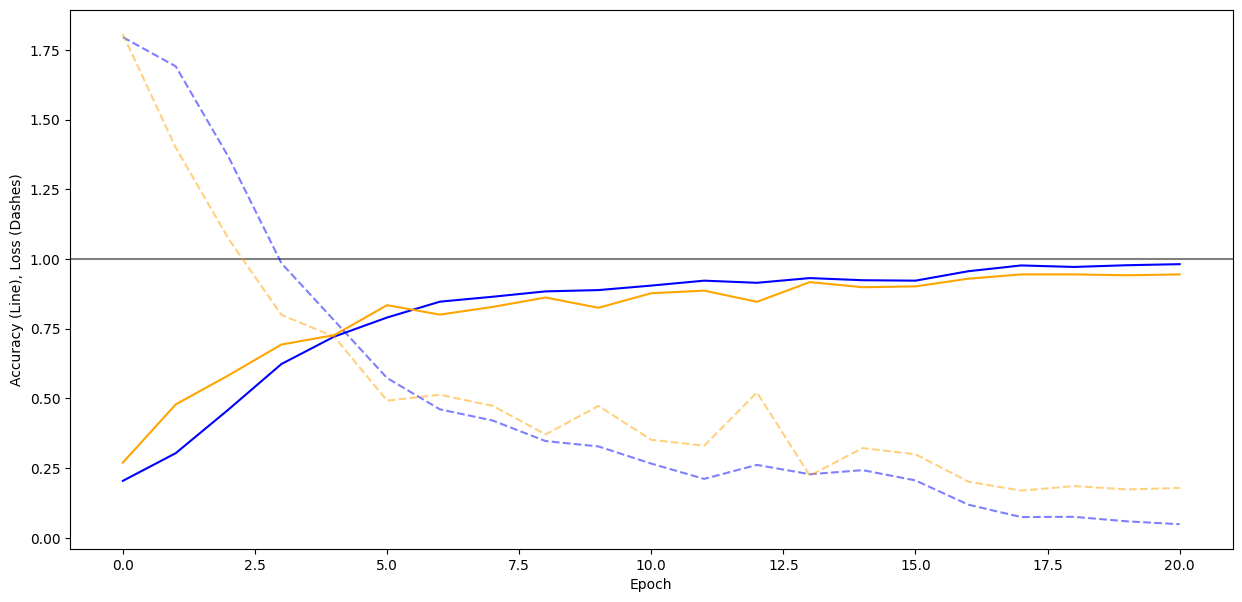

In [20]:
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

fig = plt.figure(figsize=(15, 7))
ax = plt.gca()

ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy (Line), Loss (Dashes)')

ax.axhline(1, color='gray')

plt.plot(accuracy, color='blue')
plt.plot(val_accuracy, color='orange')
plt.plot(loss, '--', color='blue', alpha=0.5)
plt.plot(val_loss, '--', color='orange', alpha=0.5)

## saving the model

the function will create a directory for your model and save structure and weights in there

sometimes you will see the .h5 format being used - even though this is a bit faster and needs less space, it comes with its limitations and isn't used that much any more

In [21]:
model.save('gesture_recognition.keras')

# and this is how you load the model
# model = keras.models.load_model("gesture_recognition")

## Neues Dataset laden und Preprocessen

In [9]:
NEW_DATASET_PATH = 'marc_dataset'

# Gesamtdatei laden
with open(f'{NEW_DATASET_PATH}/annot-marc.json') as f:
    unsorted_annotations = json.load(f)

# Einträge nach Label (Condition) filtern
annotations_marc = {condition: {} for condition in CONDITIONS}

for key, value in unsorted_annotations.items():
    labels = value.get("labels", [])
    for label in labels:
        if label in CONDITIONS:
            annotations_marc[label][key] = value

In [24]:
print(json.dumps(annotations_marc['like']['c463014d-64f4-43c5-a652-3db9565c8605'], indent=2))

{
  "bboxes": [
    [
      0.23020833,
      0.52592593,
      0.134375,
      0.27222222
    ]
  ],
  "labels": [
    "like"
  ],
  "landmarks": [
    []
  ],
  "leading_conf": 1.0,
  "leading_hand": "right",
  "user_id": "flm05277"
}


In [10]:

images_marc = [] # stores actual image data
labels_marc = [] # stores labels (as integer - because this is what our network needs)
label_names = [] # maps label ints to their actual categories so we can understand predictions later

# loop over all conditions
# loop over all files in the condition's directory
# read the image and corresponding annotation
# crop image to the region of interest
# preprocess image
# store preprocessed image and label in corresponding lists
for condition in CONDITIONS:
    for filename in tqdm(os.listdir(f'{NEW_DATASET_PATH}/{condition}')):
        # extract unique ID from file name
        UID = filename.split('.')[0]
        img = cv2.imread(f'{NEW_DATASET_PATH}/{condition}/{filename}')
        
        # get annotation from the dict we loaded earlier
        try:
            annotation = annotations_marc[condition][UID]
        except Exception as e:
            print(e)
            continue
        
        # iterate over all hands annotated in the image
        for i, bbox in enumerate(annotation['bboxes']):
            # annotated bounding boxes are in the range from 0 to 1
            # therefore we have to scale them to the image size
            x1 = int(bbox[0] * img.shape[1])
            y1 = int(bbox[1] * img.shape[0])
            w = int(bbox[2] * img.shape[1])
            h = int(bbox[3] * img.shape[0])
            x2 = x1 + w
            y2 = y1 + h
            
            # crop image to the bounding box and apply pre-processing
            crop = img[y1:y2, x1:x2]
            preprocessed = preprocess_image(crop)
            
            # get the annotated hand's label
            # if we have not seen this label yet, add it to the list of labels
            label = annotation['labels'][i]
            if label not in label_names:
                label_names.append(label)
            
            label_index = label_names.index(label)
            
            images_marc.append(preprocessed)
            labels_marc.append(label_index)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

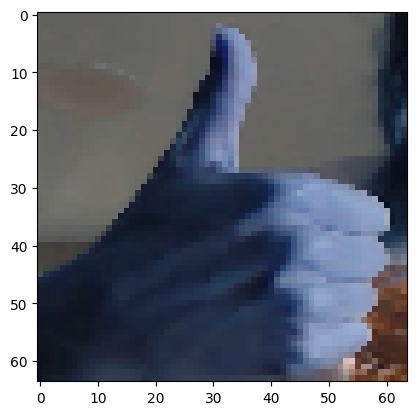

In [31]:
plt.imshow(random.sample(images_marc, 1)[0])

In [11]:
X_marc = images_marc
y_marc = labels_marc

X_marc = np.array(X_marc).astype('float32')
X_marc = X_marc / 255.

y_marc_one_hot = to_categorical(y_marc)

marc_label = y_marc_one_hot

X_marc = X_marc.reshape(-1, IMG_SIZE, IMG_SIZE, COLOR_CHANNELS)

print(X_marc.shape, marc_label.shape)

(15, 64, 64, 3) (15, 5)


## visualize classification results with a confusion matrix

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step
['like', 'no_gesture', 'dislike', 'stop', 'rock', 'peace']
Echte Labels (y_marc): [0 1 2 3 4]
Vorhergesagte Labels (y_predictions): [5.8419009e-14 2.7662345e-13 3.4640522e-13 4.5000892e-11 6.6018795e-11
 8.0317426e-11 1.2483162e-10 2.5844865e-10 3.0766634e-10 5.0824561e-10
 8.7905438e-10 1.2026870e-09 3.3458920e-09 5.4887028e-09 1.1206872e-08
 1.3201940e-08 1.4695800e-08 1.5058248e-08 1.6645794e-08 5.8162900e-08
 6.4501485e-08 1.1530722e-07 1.2165908e-07 2.2302419e-07 2.4679630e-07
 3.8104051e-07 4.0398973e-07 4.0672893e-07 4.2306900e-07 5.2329563e-07
 7.0965166e-07 8.0650528e-07 8.8708384e-07 9.9689339e-07 1.0126442e-06
 1.5143453e-06 1.5150192e-06 2.3205639e-06 2.7322096e-06 2.7676274e-06
 5.6633539e-06 5.7128509e-06 1.2513014e-05 1.5560800e-05 1.9135716e-05
 2.2787661e-05 5.3920383e-05 7.7937329e-05 8.3056744e-05 1.0851947e-04
 1.2159284e-04 1.3046374e-04 1.5507061e-04 3.9231664e-04 3.9939102e-04
 4.1361511e-04 4.3920235e-04 4.8079735e-04 4.852

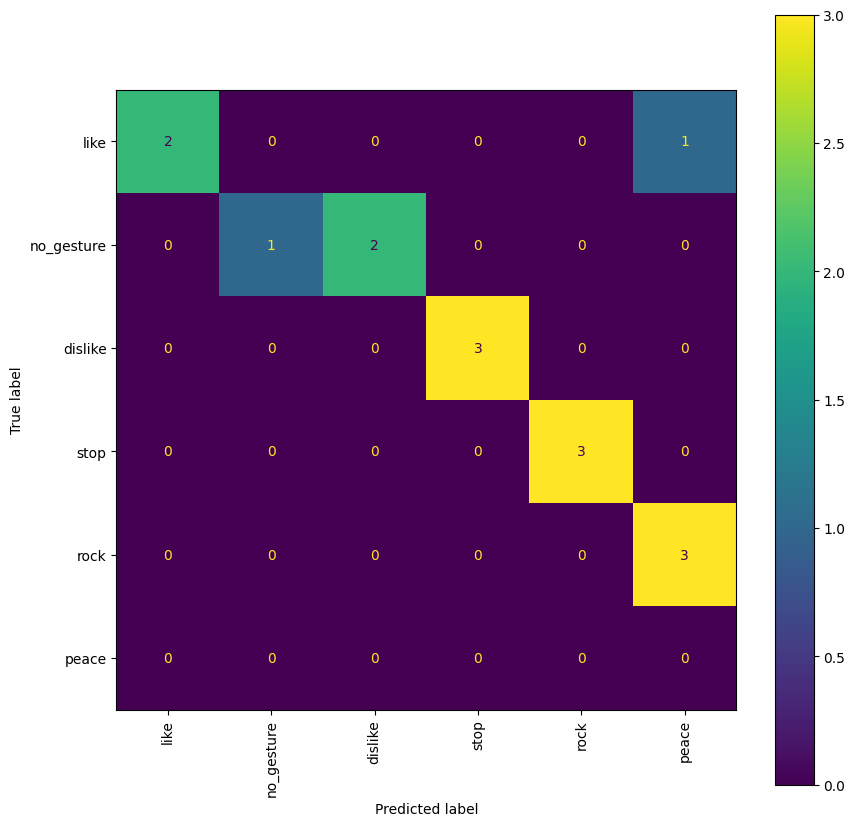

In [15]:
model = keras.models.load_model("gesture_recognition.keras")

# let the model make predictions for our training data
y_predictions = model.predict(X_marc)
label_names = ['like', 'no_gesture', 'dislike', 'stop', 'rock', 'peace']
print(label_names)
print("Echte Labels (y_marc):", np.unique(y_marc))
print("Vorhergesagte Labels (y_predictions):", np.unique(y_predictions))
# we get a 2D numpy array with probabilities for each category
print('before', y_predictions)

# to build a confusion matrix, we have to convert it to classifications
# this can be done by using the argmax() function to set the probability to 1 and the rest to 0
y_predictions = np.argmax(y_predictions, axis=1)

print('probabilities', y_predictions)

# create and plot confusion matrix
conf_matrix = confusion_matrix(y_marc, y_predictions)

fig = plt.figure(figsize=(10, 10))

ConfusionMatrixDisplay(conf_matrix, display_labels=label_names).plot(ax=plt.gca())

plt.xticks(rotation=90, ha='center')
pass

## let's test our model in action

In [ ]:
cap = cv2.VideoCapture(0)
ret, frame = cap.read()
if COLOR_CHANNELS == 1:
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
cap.release()
plt.imshow(frame)

## manual cropping for demonstration purposes - you can do better!

In [ ]:
cropped = frame[80:380, 240:410]
plt.imshow(cropped)

In [ ]:
resized = cv2.resize(cropped, SIZE)#[20:350, 200:420], SIZE)
plt.imshow(resized)
resized.shape

In [ ]:
reshaped = resized.reshape(-1, IMG_SIZE, IMG_SIZE, COLOR_CHANNELS)
reshaped.shape
prediction = model.predict(reshaped)

print(label_names[np.argmax(prediction)], np.max(prediction))

In [ ]:
filters, biases = model.layers[2].get_weights()
print(filters.shape)

fig, axes = plt.subplots(8, 8, figsize=(20, 20))

for i in range(8):
    for j in range(8):
        img = filters[:,:,:,i*8+j] * (1 / np.max(filters))
        axes[i][j].imshow(img)

In [ ]:
fig, axes = plt.subplots(8, 8, figsize=(20, 20))

for i in range(8):
    for j in range(8):
        #axes[i][j].imshow(filters[:,:,:,i*8+j] * 255, 'gray')
        kernel = filters[:,:,0,i*8+j]

        #print(kernel.shape)

        gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
        filtered = cv2.filter2D(gray, -1, kernel)

        axes[i][j].imshow(filtered, 'gray')

## Transfer Learning

let's use a pre-trained model (VGG16) for our prediction

note that VGG16 needs three color channels

In [ ]:
batch_size = 8
epochs = 50
num_classes = len(label_names)
activation = 'relu'
activation_conv = 'LeakyReLU'  # LeakyReLU
layer_count = 2
num_neurons = 256

# load a VGG16 model trained on the imagenet dataset
# include_top=False -> do not include the output layer
# input_tensor -> tells the model about the dimensions of our images (VGG16 needs three color channels)
# pooling -> which type of pooling to use between convolutions; max or avg seem to be the best
VGG = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(IMG_SIZE, IMG_SIZE, COLOR_CHANNELS)), pooling='max')

# we want to use the VGG's original weights -> make those layers untrainable
for layer in VGG.layers:
    layer.trainable = False

# build a new model and add the VGG layers
model_vgg = Sequential()
model_vgg.add(VGG)

# append dense layers at the end
for i in range(layer_count - 1):
    model_vgg.add(Dense(num_neurons, activation=activation))
model_vgg.add(Dropout(0.2))

model_vgg.add(Dense(num_neurons, activation=activation))

# classifier
model_vgg.add(Dense(num_classes, activation='softmax'))

model_vgg.compile(loss=categorical_crossentropy, optimizer="adam", metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, min_lr=0.0001)
stop_early = EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
history_vgg = model_vgg.fit(
    X_train,
    train_label,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(X_test, test_label),
    callbacks=[reduce_lr, stop_early]
)

In [ ]:
model_vgg.summary()

In [ ]:
loss = history_vgg.history['loss']
val_loss = history_vgg.history['val_loss']
accuracy = history_vgg.history['accuracy']
val_accuracy = history_vgg.history['val_accuracy']

fig = plt.figure(figsize=(15, 7))
ax = plt.gca()

ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy (Line), Loss (Dashes)')

ax.axhline(1, color='gray')

plt.plot(accuracy, color='blue')
plt.plot(val_accuracy, color='orange')
plt.plot(loss, '--', color='blue', alpha=0.5)
plt.plot(val_loss, '--', color='orange', alpha=0.5)

In [ ]:
# let the model make predictions for our training data
y_predictions = model_vgg.predict(X_test)

# we get a 2D numpy array with probabilities for each category
print('before', y_predictions)

# to build a confusion matrix, we have to convert it to classifications
# this can be done by using the argmax() function to set the probability to 1 and the rest to 0
y_predictions = np.argmax(y_predictions, axis=1)

print('probabilities', y_predictions)

# create and plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_predictions)

fig = plt.figure(figsize=(10, 10))

ConfusionMatrixDisplay(conf_matrix, display_labels=label_names).plot(ax=plt.gca())

plt.xticks(rotation=90, ha='center')
pass